In [19]:
%matplotlib inline
%load_ext tensorboard

import os
from torchvision.transforms import Compose
from torchgeo.datasets import RasterDataset

from torchgeo.transforms import indices,AugmentationSequential
import kornia.augmentation as K

from torchgeo.samplers import RandomGeoSampler
from torchgeo.datasets import stack_samples 
from torch.utils.data import DataLoader

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torchgeo.datamodules import NAIPChesapeakeDataModule
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from torchgeo.trainers import SemanticSegmentationTask
from os import path

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [20]:
root=r'E:\data\NAIP4seg'
imagery_data=os.path.join(root, "imagery") # 存储NAIP航拍影像数据
LC_data=os.path.join(root, "LC") # 存储NAIP土地覆盖分类数据
data_dir=os.path.join(root, "training") # 存储模型训练过程和结果文件

In [21]:
# 迁移于TorchGeo库：torchgeo.datamodules.naip模块
from typing import (
    Any,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
    cast,
    overload,
)

def chesapeake_transform(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the Chesapeake Dataset.

    Args:
        sample: Chesapeake mask dictionary

    Returns:
        preprocessed Chesapeake data
    """
    sample["mask"] = sample["mask"].long()[0]

    return sample

def remove_bbox(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Removes the bounding box property from a sample.

    Args:
        sample: dictionary with geographic metadata

    Returns
        sample without the bbox property
    """
    del sample["bbox"]
    return sample

chesapeak_transforms=Compose([chesapeake_transform,remove_bbox])

class delaware_lc_rd(RasterDataset):
    filename_glob="DE_STATEWIDE.tif"
    is_image=False

chesapeake=delaware_lc_rd(LC_data,transforms=chesapeak_transforms) 

In [22]:
def naip_preprocess(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the NAIP Dataset.

    Args:
        sample: NAIP image dictionary

    Returns:
        preprocessed NAIP data
    """
    sample["image"] = sample["image"].float()
    sample["image"] /= 255.0

    return sample

class naip_rd(RasterDataset):
    filename_glob = "m_*.*"
    filename_regex = r"""
        ^m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """
    is_image=True
    
    all_bands = ["R", "G", "B", "NIR"]    
    rgb_bands = ["R", "G", "B"]       

    
NDVI=indices.AppendNDVI(index_nir=3, index_red=0)
NDWI=indices.AppendNDWI(index_green=1, index_nir=3)
indeces_seq=AugmentationSequential(NDVI,NDWI,data_keys=["image"])

naip_transforms=Compose([naip_preprocess,remove_bbox,])  # indeces_seq
naip=naip_rd(imagery_data,chesapeake.crs,chesapeake.res,transforms=naip_transforms)

dataset=chesapeake & naip

torch.Size([1, 4, 256, 256])


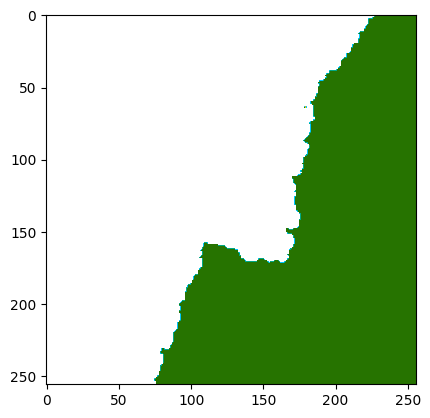

In [23]:
sampler=RandomGeoSampler(dataset,size=256, length=10)
dataloader=DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

dataloader=iter(dataloader)
batch=next(dataloader)
print(batch['image'].shape)

LC_color_dict={
    0: (0, 0, 0, 0),
    1: (0, 197, 255, 255),
    2: (0, 168, 132, 255),
    3: (38, 115, 0, 255),
    4: (76, 230, 0, 255),
    5: (163, 255, 115, 255),
    6: (255, 170, 0, 255),
    7: (255, 0, 0, 255),
    8: (156, 156, 156, 255),
    9: (0, 0, 0, 255),
    10: (115, 115, 0, 255),
    11: (230, 230, 0, 255),
    12: (255, 255, 115, 255),
    13: (197, 0, 255, 255),
    }

cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(LC_color_dict.keys()),[[v/255 for v in i] for i in LC_color_dict.values()],extend='max')
plt.imshow(np.squeeze(batch['mask']),cmap=cmap_LC);

In [27]:
batch['image']

tensor([[[[0.1843, 0.3922, 0.3216,  ..., 0.3333, 0.3922, 0.4196],
          [0.3020, 0.3373, 0.3216,  ..., 0.3216, 0.3255, 0.5765],
          [0.4314, 0.2863, 0.3294,  ..., 0.3373, 0.3569, 0.4078],
          ...,
          [0.3020, 0.3882, 0.3529,  ..., 0.3294, 0.3529, 0.2863],
          [0.4039, 0.3765, 0.3569,  ..., 0.3176, 0.2980, 0.3451],
          [0.1882, 0.2706, 0.1647,  ..., 0.2902, 0.3255, 0.3137]],

         [[0.1922, 0.4510, 0.3804,  ..., 0.4627, 0.5176, 0.4745],
          [0.2941, 0.4549, 0.3843,  ..., 0.4745, 0.5059, 0.6039],
          [0.4980, 0.3490, 0.4392,  ..., 0.4745, 0.5216, 0.4980],
          ...,
          [0.3176, 0.4980, 0.4706,  ..., 0.4863, 0.4824, 0.4902],
          [0.5137, 0.4863, 0.4863,  ..., 0.4902, 0.4235, 0.4824],
          [0.2157, 0.2431, 0.2000,  ..., 0.4667, 0.4667, 0.4667]],

         [[0.2471, 0.3529, 0.3137,  ..., 0.3412, 0.3529, 0.3725],
          [0.2706, 0.3451, 0.3137,  ..., 0.3098, 0.3098, 0.5020],
          [0.3647, 0.3059, 0.3608,  ..., 0

In [11]:
import tempfile
root = os.path.join(tempfile.gettempdir(), "naipCh")

datamodule=NAIPChesapeakeDataModule(
    #root=r'E:\data\NAIP4seg\DLoaded',
    naip_root=imagery_data,
    chesapeake_root=LC_data,
    batch_size=64,
    patch_size=256,
    length=10,
    num_workers=8,
    # naip_download=True,
    # chesapeake_download=True,     
    )

aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=8,                 # define number of output labels
)

task=SemanticSegmentationTask(
    model='unet', 
    backbone='resnet34',
    weights='imagenet',
    pretrained=True,
    in_channels=4,
    num_classes=14,
    ignore_index=7,
    loss='ce', # 'jaccard'
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
    ignore_zeros=True,
    aux_params=aux_params,
    )

In [12]:
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

checkpoint_callback=ModelCheckpoint(monitor="val_loss", dirpath=data_dir, save_top_k=1, save_last=True) #,save_on_train_epoch_end=True
early_stopping_callback=EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)
logger=TensorBoardLogger(save_dir=data_dir, name="tutorial_logs")
in_tests="PYTEST_CURRENT_TEST" in os.environ

trainer=Trainer(
    callbacks=[checkpoint_callback,early_stopping_callback], 
    logger=logger,
    default_root_dir=data_dir,
    min_epochs=1,
    max_epochs=300,
    fast_dev_run=in_tests,
    accelerator=accelerator,   
    #limit_val_batches=500,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
ckpt_path=os.path.join(data_dir,'last.ckpt')
if path.exists(ckpt_path):
    print('ckpt file exists.')
    trainer.fit(model=task,datamodule=datamodule,ckpt_path=ckpt_path)  
else:
    trainer.fit(model=task,datamodule=datamodule)

RuntimeError: Dataset not found in `root=E:\data\NAIP4seg\LC` and `download=False`, either specify a different `root` directory or use `download=True` to automatically download the dataset.

In [ ]:
https://cicwebresources.blob.core.windows.net/chesapeakebaylandcover/BAYWIDE/Baywide_13Class_20132014.zip 

---

In [16]:
from torchgeo.datasets import Chesapeake7

In [17]:
root=r'E:\data\chesapeake7'
imagery_data=os.path.join(root, "imagery") # 存储NAIP航拍影像数据
LC_data=os.path.join(root, "LC") # 存储NAIP土地覆盖分类数据
data_dir=os.path.join(root, "training") # 存储模型训练过程和结果文件

In [18]:
chesapeake7=Chesapeake7(LC_data, download=True) # crs=naip.crs, res=naip.res, 

  0%|          | 1867776/9537657730 [00:33<47:38:08, 55605.92it/s]


KeyboardInterrupt: 

In [4]:
import rioxarray
fn=r'E:\data\Delaware\lc_clipped_02.tif'
xds = rioxarray.open_rasterio(fn)

In [5]:
xds

<xarray.DataArray (band: 1, y: 2859, x: 3025)>
[8648475 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.785e+06 1.785e+06 ... 1.788e+06 1.788e+06
  * y            (y) float64 1.946e+06 1.946e+06 ... 1.944e+06 1.944e+06
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:       Area
    DataType:            Thematic
    RepresentationType:  THEMATIC
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [6]:
xds.data

array([[[3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        [3, 3, 3, ..., 0, 0, 0],
        ...,
        [5, 5, 5, ..., 0, 0, 0],
        [5, 5, 5, ..., 0, 0, 0],
        [5, 5, 5, ..., 0, 0, 0]]], dtype=uint8)

In [32]:
from torch import tensor
from torchmetrics.classification import MulticlassJaccardIndex
target = tensor([2, 1, 0, 0])
preds = tensor([2, 1, 0,  1])
metric = MulticlassJaccardIndex(num_classes=3)
metric(preds, target)

tensor(0.6667)

In [33]:
from torchmetrics.classification import MulticlassAccuracy

metric = MulticlassAccuracy(num_classes=3)
metric(preds, target)

tensor(0.8333)

In [34]:
2.5/3

0.8333333333333334